# Analysis of Burnt Areas by County in a State

This script analyses the burnt areas caused by wildfires in a specific state. The script includes:

1. **Retrieving County Boundaries**: Using a GeoJSON API to retrieve county boundaries for the selected state.
2. **Retrieving Fire Perimeters**: Retrieving fire perimeter data from an external API.
3. **Calculating Burnt Area by County**: Overlaying fire perimeters on county boundaries to calculate the burnt area for each county.
4. **Summarising Results**: Generating a summary table of burnt areas by county and saving it as a CSV file.
5. **Visualising Burnt Areas**: Creating a map to visualise the burnt areas by county, highlighting the top 5 most affected counties.

The analysis is performed for a specified state which can be changed at the bottom of the script, and the results include both table and map outputs.

In [73]:
#Install necessary libraries, uncomment if not already installed
#!pip install requests geopandas pandas matplotlib

#Import necessary libraries
import requests
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

## County Data Retrieval

This function retrieves county boundary data for a specified state from the ArcGIS REST service.

In [74]:
def get_counties_for_state(state_name):
    """
    Gets all counties for a specific state.
    
    Args:
        state_name (str): The name of the state to get counties for.
        
    Returns:
        GeoDataFrame: A GeoDataFrame containing all counties in the state.
    """
    counties_url = "https://services.arcgis.com/P3ePLMYs2RVChkJx/arcgis/rest/services/USA_Counties_Generalized_Boundaries/FeatureServer/0/query"
    
    #Set up the request
    counties_params = {
        'where': f"STATE_NAME = '{state_name}'",
        'outFields': '*',
        'returnGeometry': 'true',
        'f': 'geojson'
    }
    
    #Get the data from the server
    counties_response = requests.get(counties_url, params=counties_params)
    counties_geojson = counties_response.json()
    counties_gdf = gpd.GeoDataFrame.from_features(counties_geojson['features'])
    return counties_gdf

## Fire Data Retrieval

This function retrieves wildfire perimeter data from the WFIGS Interagency service. I ran into an issue where only 2000 perimeters were being returned so to get around this I used batch processing to retrieve all perimeters, as there may be more than 2000.

In [75]:
def get_fire_perimeters():
    """
    Gets all fire perimeters by making multiple requests.
    
    Returns:
        GeoDataFrame: A GeoDataFrame containing fire perimeters.
    """
    fires_url = "https://services3.arcgis.com/T4QMspbfLg3qTGWY/arcgis/rest/services/WFIGS_Interagency_Perimeters_YearToDate/FeatureServer/0/query"
    
    #Store all features we find
    all_features = []
    
    #Start at the beginning
    offset = 0
    batch_size = 2000
    
    print("Fetching fire perimeters in batches...")
    
    #Loop until we get all fire perimeters
    while True:
        #Set up the request for this batch
        fires_params = {
            'where': '1=1',
            'outFields': 'OBJECTID,poly_IncidentName,poly_Acres_AutoCalc',
            'returnGeometry': 'true',
            'resultRecordCount': batch_size,
            'resultOffset': offset,
            'f': 'geojson'
        }
        
        #Get the data from the server
        fires_response = requests.get(fires_url, params=fires_params)
        fires_geojson = fires_response.json()
        
        #Check if we got any features
        if 'features' not in fires_geojson or len(fires_geojson['features']) == 0:
            break
        
        #Add the features to our list
        features_in_batch = fires_geojson['features']
        all_features.extend(features_in_batch)
        
        print(f"Retrieved batch of {len(features_in_batch)} fire perimeters (total so far: {len(all_features)})")
        
        #Check if we've reached the end
        if len(features_in_batch) < batch_size:
            break
        
        #Move to the next batch
        offset += batch_size
    
    #Create a GeoDataFrame from all the features
    if all_features:
        #Make a valid GeoJSON with all features
        complete_geojson = {
            'type': 'FeatureCollection',
            'features': all_features
        }
        
        fires_gdf = gpd.GeoDataFrame.from_features(complete_geojson)
        print(f"Total fire perimeters loaded: {len(fires_gdf)}")
        return fires_gdf
    else:
        print("No fire perimeters were found.")
        return gpd.GeoDataFrame()

## Spatial Analysis

This function performs the core spatial analysis to calculate burnt area by county. It intersects county boundaries with fire perimeters and calculates the proportion of each fire that falls within each county.

In [76]:
def calculate_burnt_area_by_county(counties_gdf, fires_gdf):
    """
    Calculates the burnt area for each county.
    
    Args:
        counties_gdf (GeoDataFrame): GeoDataFrame containing county boundaries
        fires_gdf (GeoDataFrame): GeoDataFrame containing fire perimeters
        
    Returns:
        DataFrame: A DataFrame with burnt area calculations by county.
    """
    #Check if we have fire data
    if fires_gdf.empty:
        print("No fire perimeters found for analysis.")
        return pd.DataFrame(columns=['County', 'FIPS', 'Burnt Area (Acres)'])
    
    #Make sure the coordinate systems match
    if counties_gdf.crs != fires_gdf.crs and fires_gdf.crs is not None:
        print("Converting coordinate systems to match...")
        counties_gdf = counties_gdf.to_crs(fires_gdf.crs)
    
    #Create a list to store our results
    results = []
    
    print("Calculating fire area by county...")
    print(f"Measuring {len(counties_gdf)} counties against {len(fires_gdf)} fire perimeters.")
    
    #Look at each county
    for county_row in counties_gdf.itertuples():
        county_name = county_row.NAME
        county_geom = county_row.geometry
        
        #Find fires that overlap with this county
        overlapping_fires = fires_gdf[fires_gdf.intersects(county_geom)]
        
        #Calculate total burnt acres for this county
        total_burnt_acres = 0
        
        #If there are overlapping fires
        if not overlapping_fires.empty:
            for fire_row in overlapping_fires.itertuples():
                fire_geom = fire_row.geometry
                
                #Find where the fire and county overlap
                intersection = county_geom.intersection(fire_geom)
                
                #Calculate what percentage of the fire is in this county
                if not intersection.is_empty:
                    proportion = intersection.area / fire_geom.area
                    burnt_acres = fire_row.poly_Acres_AutoCalc * proportion
                    total_burnt_acres += burnt_acres
        
        #Add this county's results to our list
        results.append({
            'County': county_name,
            'Burnt Area (Acres)': round(total_burnt_acres, 2)
        })
    
    #Create a DataFrame and sort by burnt area
    results_df = pd.DataFrame(results).sort_values('Burnt Area (Acres)', ascending=False)
    return results_df

## Analysis Function

This function coordinates the complete analysis process for a specified state. It retrieves county and fire data, calculates burnt area by county, saves the results to a CSV file, and returns both the results and geographic data for mapping.

In [77]:
def summarise_burnt_area_for_state(state_name):
    """
    Creates a summary of burnt area by county for a specified state.
    
    Args:
        state_name (str): The name of the state to analyse
        
    Returns:
        tuple: A tuple containing (results_df, counties_gdf) where:
            - results_df is a DataFrame with burnt area by county
            - counties_gdf is the GeoDataFrame with county boundaries
    """
    print(f"Starting analysis for {state_name}...")
    
    #Get county boundaries
    counties_gdf = get_counties_for_state(state_name)
    
    #Get fire perimeters
    fires_gdf = get_fire_perimeters()
    
    #Calculate burnt area by county
    results_df = calculate_burnt_area_by_county(counties_gdf, fires_gdf)
    
    #Save results to a CSV file
    output_file = f"burnt_area_by_county_{state_name.replace(' ', '_')}.csv"
    results_df.to_csv(output_file, index=False)
    print(f"Results saved to {output_file}")
    
    #Return both the results DataFrame and the counties GeoDataFrame for mapping
    return results_df, counties_gdf

## Map Visualisation

This function creates a map Visualisation of burnt area by county. It colors counties based on burnt acreage and labels the top 5 most affected counties.

In [78]:
def create_burnt_area_map(results_df, counties_gdf, state_name):
    """
    Creates a map showing burnt area by county, labeling only the top 5 most burnt counties.
    
    Args:
        results_df (DataFrame): DataFrame with burnt area results
        counties_gdf (GeoDataFrame): GeoDataFrame with county boundaries
        state_name (str): Name of the state for map title

    Returns:
        fig: The matplotlib figure object containing the map
    """
    #Make a copy of the counties GeoDataFrame to avoid modifying the original
    map_counties = counties_gdf.copy()
    
    #Create a 'Burnt Area (Acres)' column in the counties GDF and initialise with zeros
    map_counties['Burnt Area (Acres)'] = 0
    
    #Update the 'Burnt Area (Acres)' values for counties that have burn data
    #This ensures we keep ALL counties, even those with no fires
    for _, row in results_df.iterrows():
        #Find the county in our GeoDataFrame and update its burn acres
        county_indices = map_counties[map_counties['NAME'] == row['County']].index
        if len(county_indices) > 0:
            map_counties.loc[county_indices, 'Burnt Area (Acres)'] = row['Burnt Area (Acres)']
    
    #Create a figure and axis for the map
    fig, ax = plt.subplots(1, 1, figsize=(15, 12))
    
    #Define a colormap for fire
    cmap = 'OrRd'  #Orange-Red colormap
    
    #Plot the counties with the burnt area as the color using a linear scale
    map_counties.plot(column='Burnt Area (Acres)', 
                    ax=ax, 
                    cmap=cmap,
                    legend=True, 
                    legend_kwds={'label': "Burnt Acres", 'shrink': 0.8})
    
    #Add county boundaries with black outline
    map_counties.boundary.plot(ax=ax, linewidth=0.5, color='black')
    
    #Get the top 5 counties with the most burnt area
    top_5_counties = map_counties.sort_values('Burnt Area (Acres)', ascending=False).head(5)
    
    #Add labels for only the top 5 counties
    for _, county in top_5_counties.iterrows():
        #Only label burnt area
        if county['Burnt Area (Acres)'] > 0:
            #Get the centroid of the county for label placement
            centroid = county['geometry'].centroid
                
            #Use the corrected name in the label
            ax.text(centroid.x, centroid.y, f"{county['NAME']}\n({county['Burnt Area (Acres)']:.1f} acres)", 
                fontsize=7, ha='center', va='center', fontweight='bold',
                bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.2', edgecolor='black'))
    
    #Set the title and turn off the axis
    ax.set_title(f'Burnt Area by County in {state_name}', fontsize=16)
    ax.set_axis_off()
    
    #Add summary information
    counties_with_fires = map_counties[map_counties['Burnt Area (Acres)'] > 0]
    plt.figtext(0.5, 0.01, 
               f"Total Burnt Area: {map_counties['Burnt Area (Acres)'].sum():,.2f} acres across {len(counties_with_fires)} of {len(map_counties)} counties", 
               ha='center', fontsize=12)
    
    #Save the map to a file
    map_file = f"burnt_area_map_{state_name.replace(' ', '_')}.png"
    plt.savefig(map_file, dpi=300, bbox_inches='tight')
    print(f"Map saved to {map_file}")
    
    #Show the map
    plt.tight_layout()
    plt.show()
    
    #return fig

## Run the Analysis

The code below allows you to analyse burnt area for any state. Change the state name variable to run the analysis for a different state. The results will be displayed as a table and map.

Starting analysis for Utah...
Fetching fire perimeters in batches...
Retrieved batch of 2000 fire perimeters (total so far: 2000)
Retrieved batch of 274 fire perimeters (total so far: 2274)
Total fire perimeters loaded: 2274
Calculating fire area by county...
Measuring 29 counties against 2274 fire perimeters.
Results saved to burnt_area_by_county_Utah.csv
               County  Burnt Area (Acres)
28       Weber County              455.26
23      Uintah County              121.88
6     Duchesne County              108.80
20      Sevier County               69.48
10        Iron County               47.20
2        Cache County               33.25
1    Box Elder County                6.29
26  Washington County                2.13
9        Grand County                0.19
4      Daggett County                0.00
3       Carbon County                0.00
0       Beaver County                0.00
5        Davis County                0.00
12        Kane County                0.00
11        J

C:\Users\Mike (Admin)\AppData\Local\Temp\ipykernel_32620\4005968404.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '455.26' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  map_counties.loc[county_indices, 'Burnt Area (Acres)'] = row['Burnt Area (Acres)']


Map saved to burnt_area_map_Utah.png


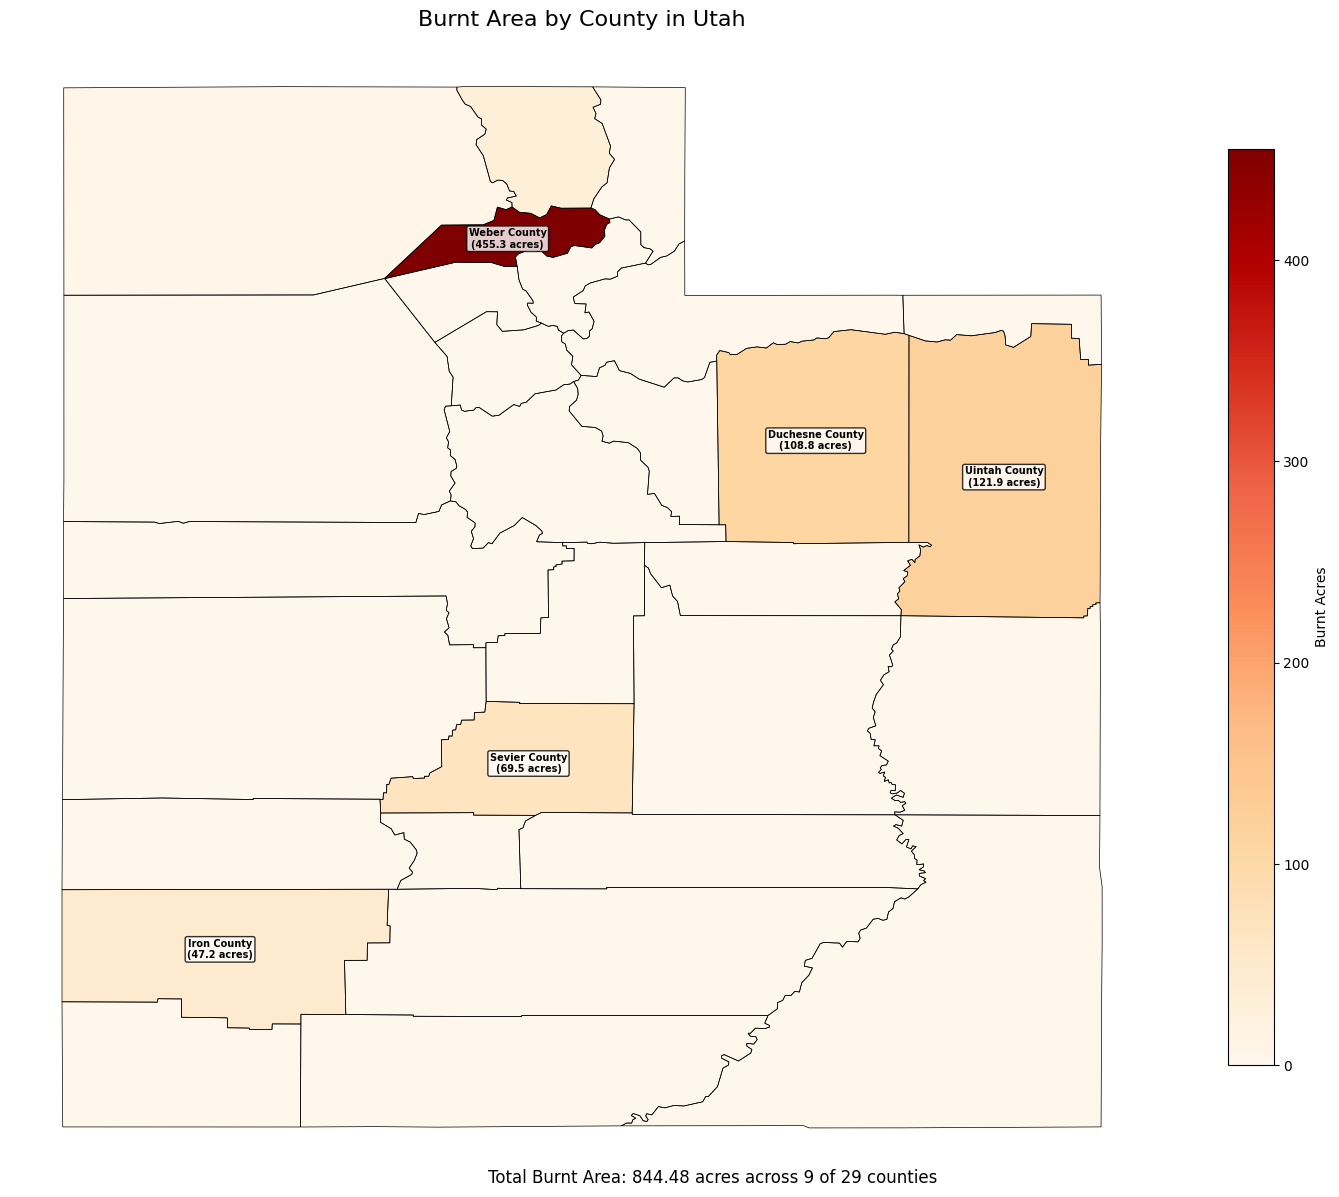

In [79]:
#1. Change your state here
state_name = "Utah"

#2. Run the analysis
burnt_area_df, counties_gdf = summarise_burnt_area_for_state(state_name)

#3. Display the pandas table
print(burnt_area_df)

#4. Create a map showing burnt area by county
create_burnt_area_map(burnt_area_df, counties_gdf, state_name)